In [1]:
import numpyro
numpyro.set_host_device_count(4)
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import warnings
warnings.filterwarnings('ignore', message='The RandomType SharedVariables')

plt.rcParams.update({
    'figure.figsize': (14, 4),
    'figure.dpi': 144,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.linestyle': '--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False,
    'figure.constrained_layout.use': True
})

import numpy as np
seed = sum(map(ord, 'Why Statespace?'))
rng = np.random.default_rng()

In [2]:
def plot_timeseries_posterior(idata, data=None, ax=None, color='tab:blue', data_color='k', label=None):
    if ax is None:
        fig, ax = plt.subplots()

    mu = idata.mean(dim=['chain', 'draw'])
    hdi = az.hdi(idata)
    key = list(hdi.data_vars.keys())[0]
    hdi = hdi[key]
    
    x_values = mu.coords['time'].values

    ax.plot(x_values, mu, color=color, label=label)
    ax.fill_between(x_values, *hdi.values.T, alpha=0.25, color=color, label=f'{label} HDI 94%' if label is not None else None)
    
    if data is not None:
        ax.plot(x_values, data, color=data_color, ls='--', label='Data')
    
    if label is not None:
        ax.legend()
    
    return ax

# Who Am I

Jesse Grabowski, PhD Candidate at Paris 1 Pantheon-Sorbonne
- (Former) Macroeconomist, OECD Development Center
- Principal Data Scientist, PyMC Labs
- Core Developer, PyMC and Pytensor

# Today's Agena

- Introduction to structural time series modeling in PyMC
- A quick look at how to do it "by hand"
- Hard cut to the `pymc_experimental.statespace` module, and a look at the basics
- VAR modeling with `pymc_experimental.statespace`, forecasting, and computing impulse response functions
- Structural time series modeling with exogenous variables and scenario-based forecasting
- Custom structural models using a non-linear DSGE

Very ambitious! We'll see how far we get.

Materials available at 

# Why Time Series?

Every model should probably include time. But they don't because working with time is a huge pain in the ass. The purpose of the `pymc-statespace` sub-module is to alleviate some of these issues.

## Issue 1: Model selection

Which time series model should you use? How should you choose between them? 

Jumping between time series "families" (ARIMA, GARCH, ETS, VARMAX, etc), it's not trivial to do the type of incremental Bayesian workflow that PyMC does so well.

## Issue 2: Getting your outputs

What output do you want? Conditional moments? Unconditional moments? Forecasting distributions? Impulse response functions? Something more exotic?

We will see in a second that when you write tiem series models by hand, getting these are non-trivial.

## Issue 3: How to handle missing data? 

If you want to compute one-step ahead prediction residuals, what do you do when there is no data? You will need to marginalize the observation distribution in this case, which is not always easy to do.

## Issue 4: How to mix time structure into a "normal" model?

How to embed a static problem into each time step (that is, define a time-series process over the *residuals* of a typical model)? Consider this model:

$$ 
\begin{align}
y_t &= \alpha + X_t \beta + \eta_t \\
\eta_t &= \rho \eta_{t-1} + \theta \varepsilon_{t-1} + \varepsilon_t
\end{align}
$$

This type of structure arises in a lot contexts. We could imagine, for example, that the $X_t$ are covariates we are interested in causally, but do not themselves have a time series structure to them (adveristing spend, for example). We want to do a static regression of X on y at each timestep, then allow the residuals of this regression to be ARMA(1,1) distributed. 

You might have tried to plug residuals into the `observed=` argument of a PyMC distribution only to find that this is not allowed!

These are "fundimental" problems in time series, in the sense that you will have to address them in any PPL. PyMC, for all its expressive power, also offers some unique challenges in time series modeling:

1. What is `scan`? What are all the ins, outs, and corner cases I need to know? 
2. How is CustomDist used? What are the limitations?
3. How should I recover hidden states?
4. How can I do forecasting?

This presentation won't answer any of these questions! Come hang out on the PyMC discourse if you have them:

https://discourse.pymc.io/

# Motivating Example: AR(1)

The purpose of `pymc-statespace` is to abstract away all of these issues and help you focus directly on modeling your time series. This comes with some flexibility cost, but we've tried to keep things as flexible as possible.

Let's begin by looking at what a time series model looks like in pure PyMC. 

As an aside, in this presentation, I define a "time series model" as follows:

$$ x_t = g(x_{t-1}, \epsilon_t)$$

Where $g$ is a deterministic **policy function** that explains how we should update the **state** of the system $x_t$, given the past state, $x_{t-1}$, and some stochastic shocks, $\varepsilon_t$. In this form, I make no assumptions about either $g$ or $\varepsilon_t$. 

Aside of an aside: Engineers in the audiance might be used to seeing something like $g(x_t, u_t, \varepsilon_t)$, where $x_t$ is the state of the system, and $u_t$ are **control inputs** into the system that we're allowed to choose. These are equivalent -- we can always just stack the states and controls together into a new state vector. 

A simple but non-trivial example of a model is the AR(1) model:

$$
x_t = \rho x_{t-1} + \varepsilon_t
$$

In this case, $g$ is quite simple -- we just scale the past value and add in the noise. The only visible parameter in this equation is $\rho$, which ends up describing the persistance of shocks on the system. When $\rho = 0$, $x_t$ is just iid white noise. When $\rho = 1$, $x_t$ follows a gaussian random walk. 

Another parameter we always need to define is $x_0$, the initial state of the system. 

Finally, we have to make some assumptions about $\varepsilon_t$. The most common one is that it's iid Normal with mean 0 and variance $\sigma^2$. So we have to also estimate $\sigma$.

That brings our model to a total of 3 parameters.

In [3]:
import pymc as pm
from pymc.pytensorf import collect_default_updates

time_idx = pd.date_range(start='2000-01-01', end='2024-08-01', freq='MS')
coords = {'time': time_idx}

with pm.Model(coords=coords) as ar1_model:
    
    # Define prior -- stationary only please
    rho = pm.Beta('rho', alpha=1, beta=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Define prior initial state
    x0 = pm.Normal('x0')
    
    # Make a wrapper function for pm.CustomDist that returns a random vector
    def ar1_dist(x0, rho, sigma, shape=None):
        
        # Define a recursive relationship mapping x_{t-1} to x_t
        def step(x_tm1, rho, sigma):
            x_t = rho * x_tm1 + pm.Normal.dist(0, sigma)
            return x_t, collect_default_updates(x_t)
        
        sequence, update = pytensor.scan(step,
                                         outputs_info=[x0],
                                         non_sequences=[rho, sigma],
                                         n_steps = len(ar1_model.coords['time']),
                                         strict=True)
        return sequence
    
    obs = pm.CustomDist('obs', x0, rho, sigma, dist=ar1_dist, dims=['time'])
    
    prior = pm.sample_prior_predictive(random_seed=rng)

Sampling: [obs, rho, sigma, x0]


Use a random draw from the prior as data

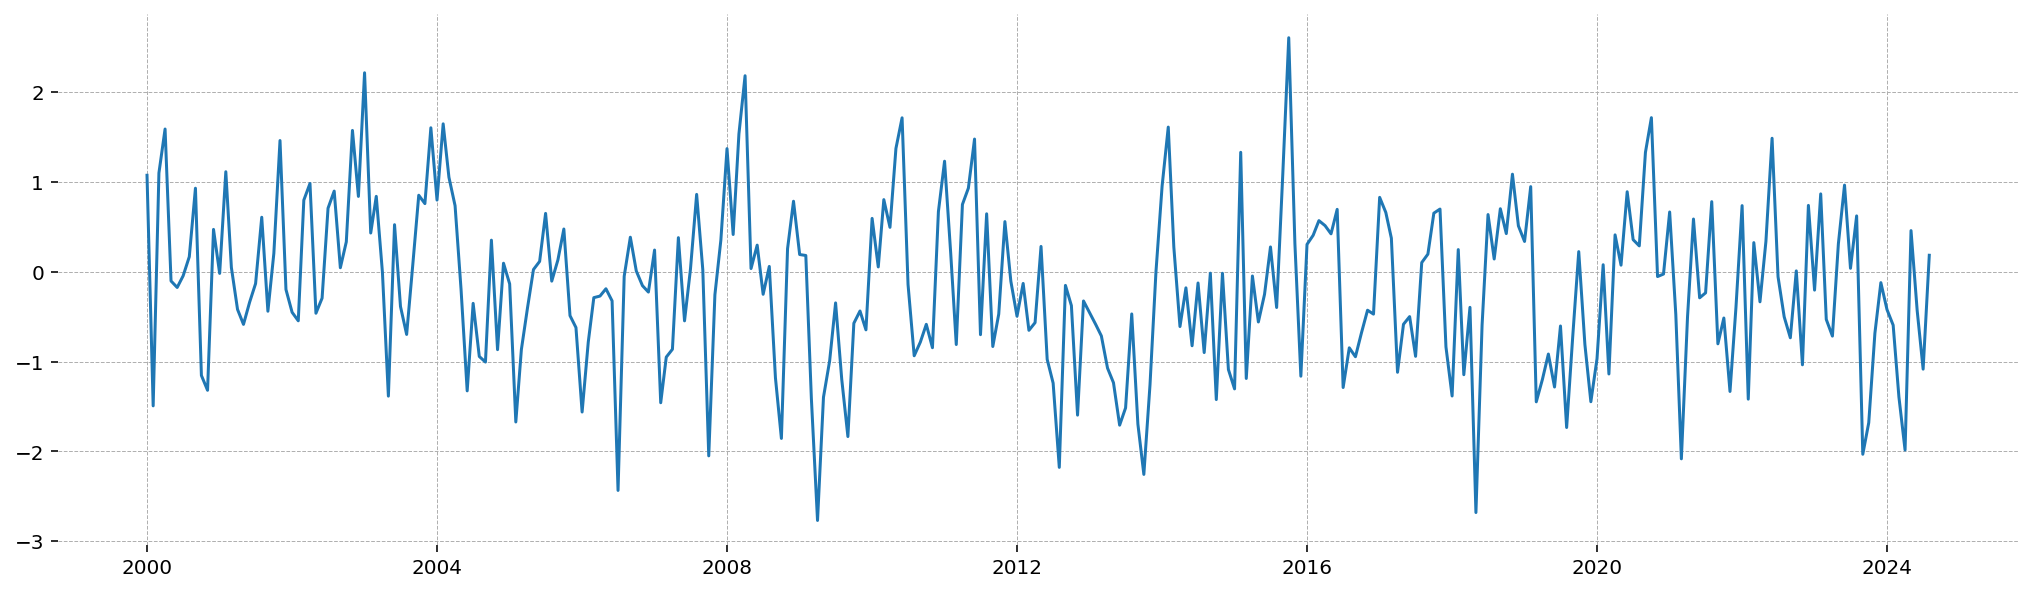

In [4]:
draw = rng.choice(500)
sample = pd.Series(prior.prior.obs.sel(chain=0, draw=draw),
                   index=time_idx)

true_params = [prior.prior[var].sel(chain=0, draw=draw) for var in ['x0', 'rho', 'sigma']]
plt.plot(sample)

Next, use `pm.observe` to add this data back into the model and do a parameter recovery exercise

In [5]:
with pm.observe(ar1_model, {'obs':sample}):
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma, x0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


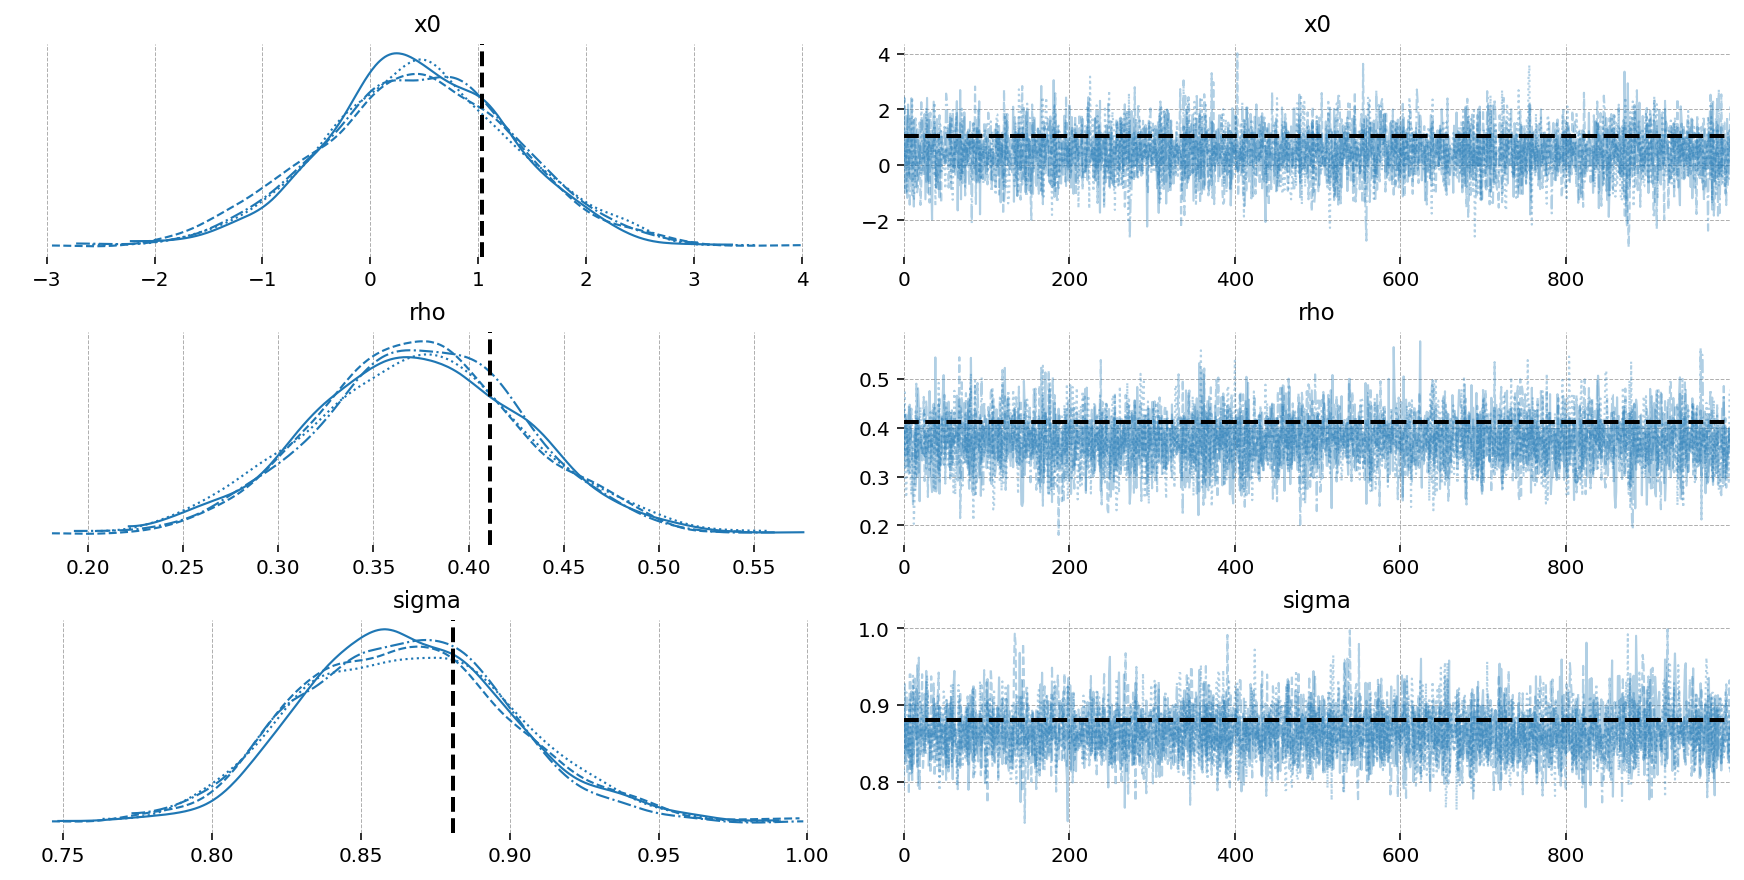

In [6]:
axes = az.plot_trace(idata, var_names = ['x0', 'rho', 'sigma'])
for (axis, ref_val) in zip(axes[:, 0], true_params):
    axis.axvline(ref_val, c='k', lw=2, ls='--')
for (axis, ref_val) in zip(axes[:, 1], true_params):
    axis.axhline(ref_val, c='k', lw=2, ls='--')

What you get back from this model might surprise you! We've learned the *unconditional* time series distribution. When we sample the posterior predictive, we get length $T$ trajectories starting from $x_0$. If you're used to looking at outputs from `statsmodels`, for example, these will not be what you expect. 

In [7]:
with pm.observe(ar1_model, {'obs':sample}):
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [obs]


Output()

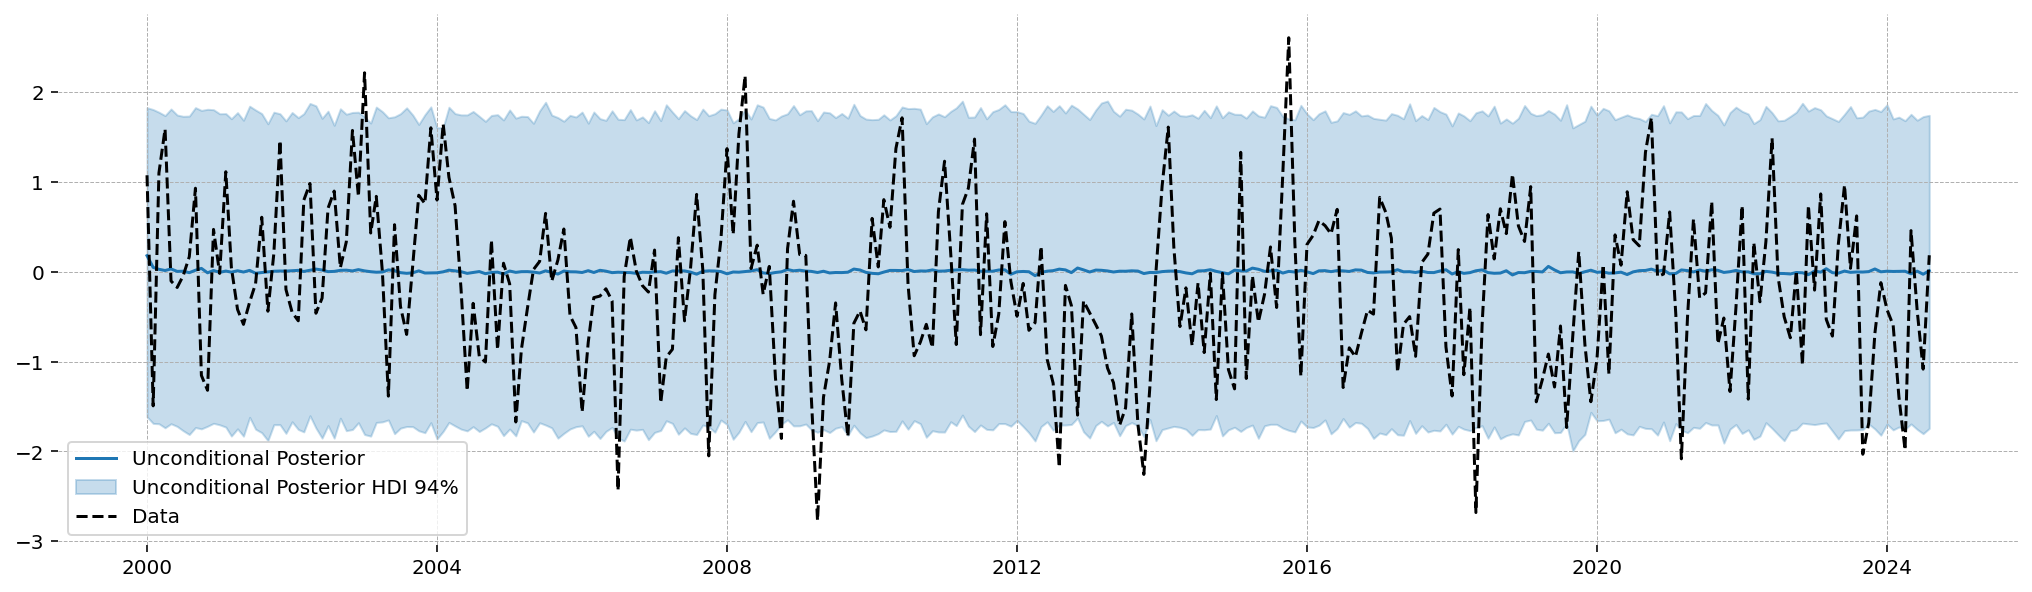

In [8]:
plot_timeseries_posterior(idata.posterior_predictive.obs, data=sample.values, label='Unconditional Posterior');

It is possible to proceed from here and use a secondary model to obtain the one-step ahead forecasts. This requires you to pass in data to the `scan` inner function, make a one-step forecast, then pass in the next data, and so on. This procedure is beyond the scope of this talk, if you're interested check out this new tutorial:

https://www.pymc.io/projects/examples/en/latest/time_series/Time_Series_Generative_Graph.html

## AR(1) using statespace

Let's see another way to implement this model. We can use the `BayesianSARIMAX` model class from `pymc_experimental.statespace`, with one autoregressive lag.

The constructor API follows `statsmodels.tsa.statespace` very closely, so it should feel familiar to anyone who has used that package

In [9]:
import pymc_experimental.statespace as pmss
ss_mod = pmss.BayesianSARIMA(order=(1, 0, 0),  # (ar_lags, difference, ma_lags)
                             seasonal_order=(0, 0, 0, 0), # (ar_lags, difference, ma_lags, season_period)
                             state_structure='fast', # There are several ways to write the ARIMA model.
                                                     # "fast" mixes stuff together to make the matrices smaller,
                                                     # but the cost is that the hidden states are nonsense
                             stationary_initialization=True, # Whether to assume the system starts in the steady-state.
                                                             # If false, you have to specify x0 and P0 
                             measurement_error=False  # Whether to fully trust your data or not. If True, you need
                                                      # to specify a prior for the observation error std
                            )

The following parameters should be assigned priors inside a PyMC model block: 
	ar_params -- shape: (1,), constraints: None, dims: ('ar_lag',)
	sigma_state -- shape: None, constraints: Positive, dims: ()


### What's in a `PyMCStateSpace` object?

`pmss.BayesianSARIMA` is meant to be a bridge between a full PyMC model and a ready-to-use API like `statsmodels.tsa.statespace`. In fact, I flagrently copied `statsmodels`, so the API for the constructor should feel similar.

Under the hood, things are quite different, reflecting the idieosyncracies of a PyMC model. First, let's look at how one would use the instantianted statespace model.

We are told we need to specify two variables: `ar_params` (which is what we called `rho` above) and `sigma_state` (which we called `sigma` above).

We don't need to specify `x0` because we asked for `stationary_initialization=True`.

In [10]:
with pm.Model(coords=ss_mod.coords) as ar1_ss_mod:
    # To emphasize that statespace models look for parameters based on their *names*, I don't assign the
    # priors to variables. They are still added to the computational graph and used as expected!
    pm.Beta('ar_params', 1, 1, dims=['ar_lag'])
    pm.Exponential('sigma_state', lam=1)
    
    # To look for these variables and create the model, call the `build_statespace_graph` method, providing
    # the observed data.
    ss_mod.build_statespace_graph(data=sample, mode='JAX')

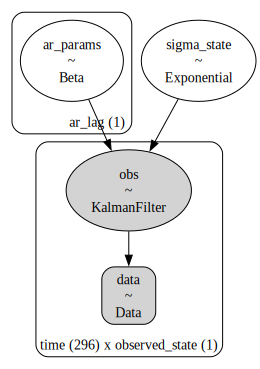

In [11]:
ar1_ss_mod.to_graphviz()

In [12]:
with ar1_ss_mod:
    # Then sample as usual!
    idata_ss = pm.sample(nuts_sampler='numpyro')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Important detail 1: `ss_mod.coords`

All statespace models have a `coords` property that gives you the coordinates needed for the PyMC model. Here are the coords for this model. **All** statespace models have the `state`, `observed_state`, and `shock` dimensions, even if they aren't used. 

(Dimensions that are *always* length 1 won't use a labeled dimension. In this case, we used `ar_lag` because we could have made it longer by asking for more lags. But we didn't use `shock` anywhere, because it's always length 1 regardless of the settings).

In [13]:
ss_mod.coords

{'state': ['data'],
 'state_aux': ['data'],
 'observed_state': ['data'],
 'observed_state_aux': ['data'],
 'shock': ['innovation'],
 'shock_aux': ['innovation'],
 'ar_lag': [1]}

### Important detail 2: `ss_mod.build_statepace_graph`

The `build_statespace_graph` method is the most important thing a `PyMCStateSpace` model does. Every statespace model comes with a set of symbolic matrices objects that describe how to build the system. The `build_statespace_graph` method is responsible for inserting PyMC `RandomVariables` into these symbolic matrices. It does this by matching on *variable names*. That's why we have to follow the instructions we're giving when we instantiate a model.

The 2nd thing `build_statespace_graph` does is creates a `KalmanFilter` and uses it to compute the log likeihood of the provided data under the model. More on this later.

If you do not call `build_statespace_graph`, your model will not do anything!

### Interlude: Outputs

Before discussing other important functionality of a state space model, let's check how sampling went.

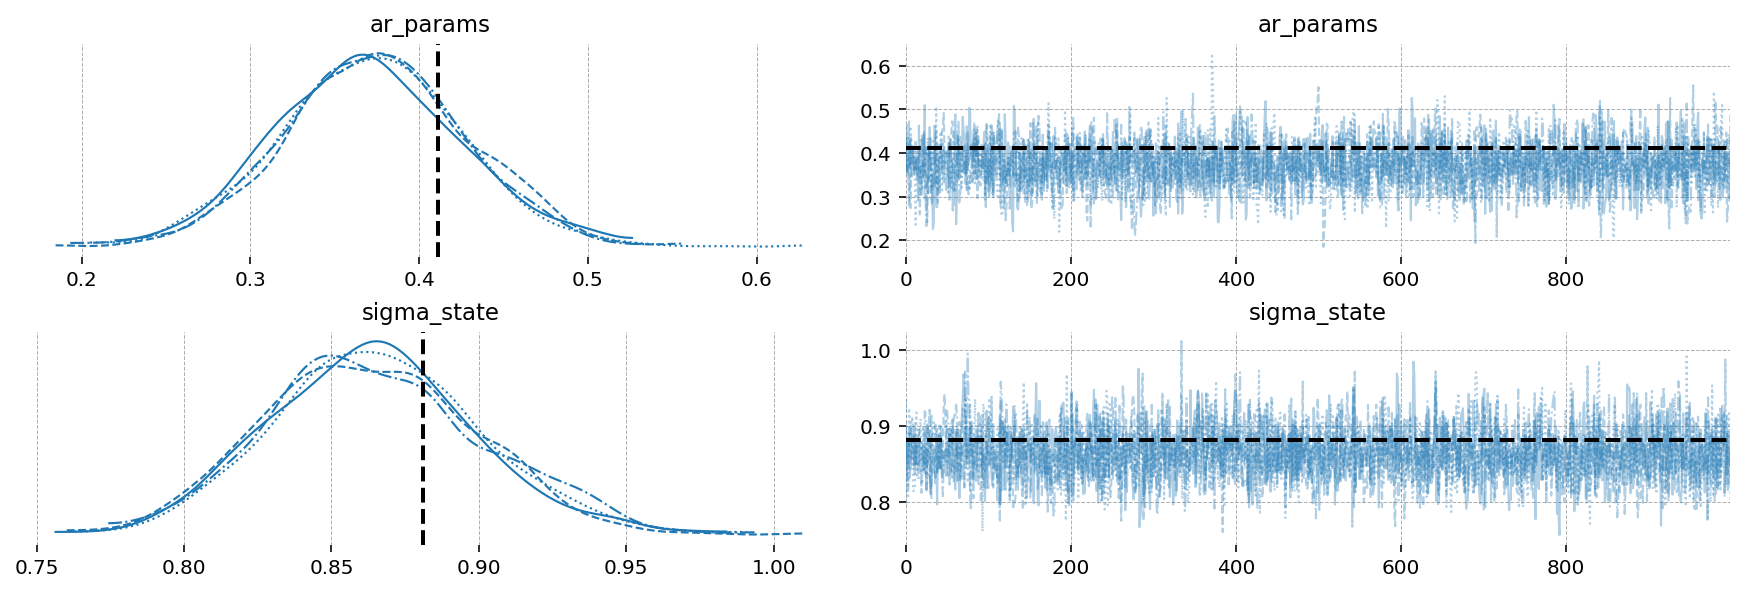

In [14]:
axes = az.plot_trace(idata_ss, var_names = ['ar_params', 'sigma_state'])
for (axis, ref_val) in zip(axes[:, 0], true_params[1:]):
    axis.axvline(ref_val, c='k', lw=2, ls='--')
for (axis, ref_val) in zip(axes[:, 1], true_params[1:]):
    axis.axhline(ref_val, c='k', lw=2, ls='--')
plt.show()

### Important detail 3: Post-estimation sampling

After you've sampled a model, you're going to want to do stuff with it. Typical tasks include:

1. Sample the posterior predictive
2. Forecast
3. Look at impulse response functions
4. Compute estimated posterior moments
5. Variance decomposition

Only (1), (2), and maybe (4) are relevant for an ARIMA model, since we don't have multiple timeseries (so the IRFs aren't interesting) and only one structural shock (so there's nothing to decompose in the variance).

### Important Detail 3.1: Posterior Predictive Sampling

Let's look at posterior predictive sampling. First important question is "which posterior"? We already saw the unconditional posterior in the full PyMC model. This is the posterior over trajectories starting from $x_0$. We can sample it here using the `sample_unconditional_posterior` method. 

**important**: All of these post-estimation sampling methods are called *outside* a PyMC model context. The reason is that inside, they are build you a new PyMC model and using your posterior samples to sample it. For details on this "predictive model" procedure, see this blog:

https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/

In [15]:
unconditional_post = ss_mod.sample_unconditional_posterior(idata_ss)
unconditional_post

Sampling: [posterior_combined]


Output()

<xarray.Dataset> Size: 19MB
Dimensions:             (chain: 4, draw: 1000, time: 296, state: 1,
                         observed_state: 1)
Coordinates:
  * chain               (chain) int64 32B 0 1 2 3
  * draw                (draw) int64 8kB 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * time                (time) datetime64[ns] 2kB 2000-01-01 ... 2024-08-01
  * state               (state) <U4 16B 'data'
  * observed_state      (observed_state) <U4 16B 'data'
Data variables:
    posterior_latent    (chain, draw, time, state) float64 9MB 0.7024 ... 0.7742
    posterior_observed  (chain, draw, time, observed_state) float64 9MB 0.702...
Attributes:
    created_at:                 2024-08-26T14:22:17.372929+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

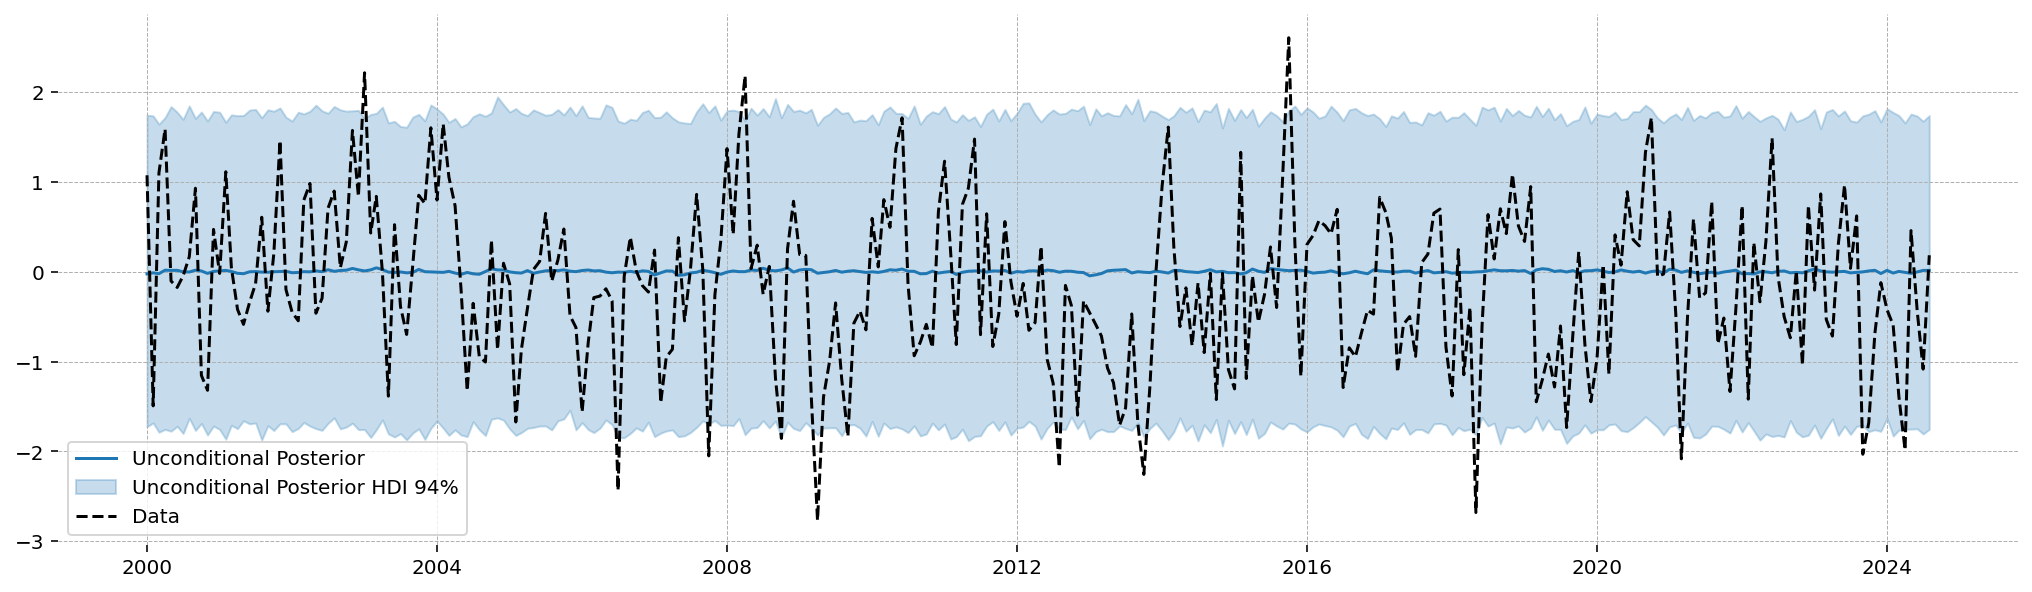

In [16]:
plot_timeseries_posterior(unconditional_post.posterior_observed.isel(observed_state=0),
                          data=sample.values,
                          label='Unconditional Posterior');

### Important Detail 3.2: Conditional Posterior Sampling

But what's more interesting is that we can also ask for the *conditional* posterior, which is likely what we wanted all along. This is the distribution of one-step-ahead predictions. It works like this:

1. Take the first data point, $x_1$.
2. Run the model for one step using our posterior parameters.
3. Save the resulting distrbution
4. Move to the next data point and repeat. 

To use this, use the cleverly named `sample_conditional_posterior`

In [17]:
conditional_post = ss_mod.sample_conditional_posterior(idata_ss)
conditional_post

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

<xarray.Dataset> Size: 57MB
Dimensions:                       (chain: 4, draw: 1000, time: 296, state: 1,
                                   observed_state: 1)
Coordinates:
  * chain                         (chain) int64 32B 0 1 2 3
  * draw                          (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * time                          (time) datetime64[ns] 2kB 2000-01-01 ... 20...
  * state                         (state) <U4 16B 'data'
  * observed_state                (observed_state) <U4 16B 'data'
Data variables:
    filtered_posterior            (chain, draw, time, state) float64 9MB 1.07...
    filtered_posterior_observed   (chain, draw, time, observed_state) float64 9MB ...
    predicted_posterior           (chain, draw, time, state) float64 9MB 1.03...
    predicted_posterior_observed  (chain, draw, time, observed_state) float64 9MB ...
    smoothed_posterior            (chain, draw, time, state) float64 9MB 1.07...
    smoothed_posterior_observed   (chain, draw, time, observed_state) float64 9MB ...
Attributes:
    created_at:                 2024-08-26T14:22:32.135549+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

I would wager this plot is what you were expecting to get all along, because this is what is produced by e.g. STATA, SASS, or `statsmodels`. 

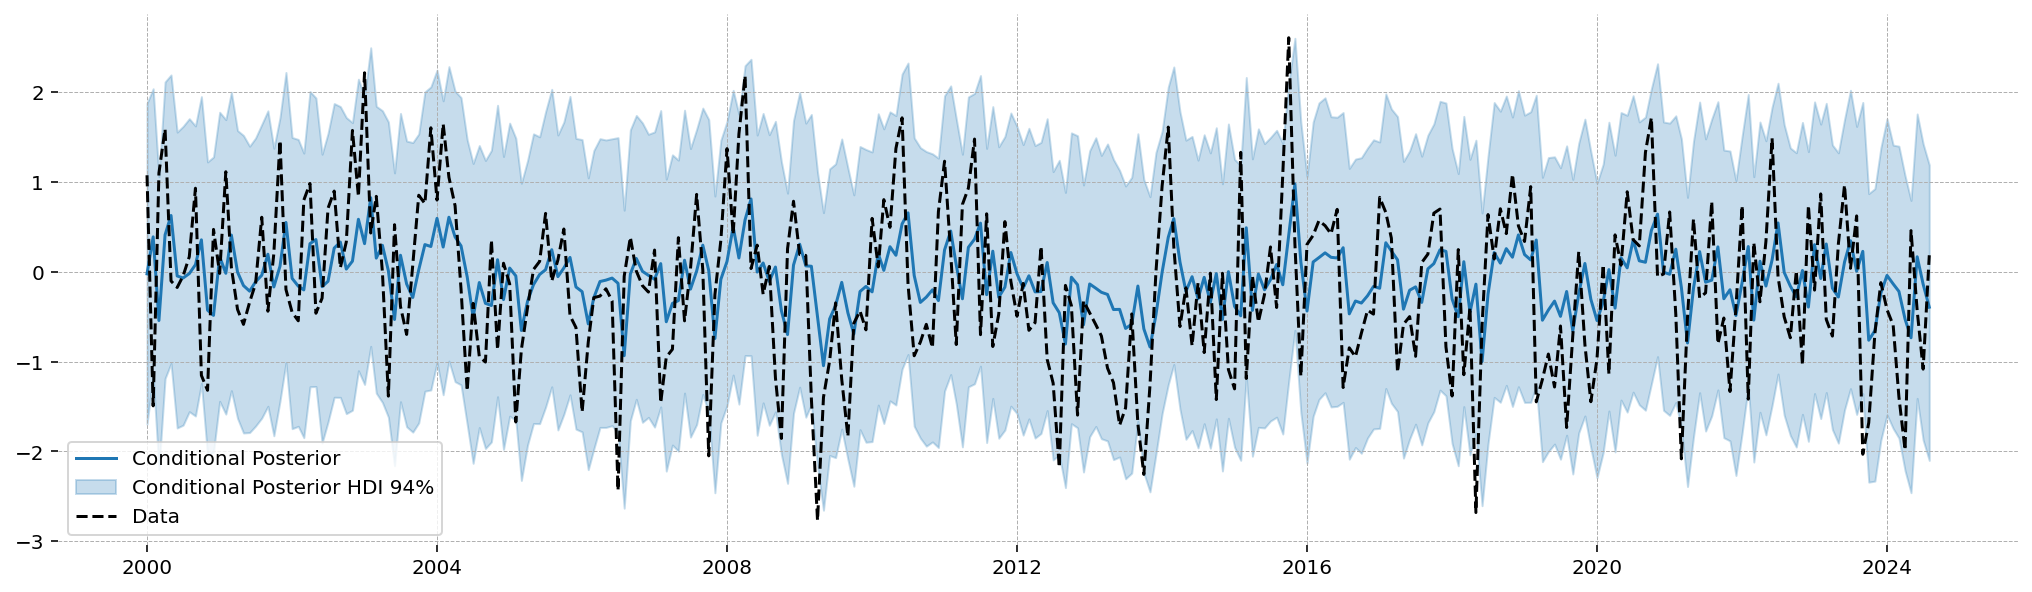

In [18]:
plot_timeseries_posterior(conditional_post.predicted_posterior_observed.isel(observed_state=0),
                          data=sample.values,
                          label='Conditional Posterior');

### Important point 3.3: Forecasting


Perhaps the most important post-estimation task is forecasting. This is once again possible in "pure" PyMC, but the statespace model handles all the nitty-gritty details for you in the `forecast` function. All we have to do provide:

1. The start date (by default it's the last value of the data index)
    1. You can pass either an actual date string (`start="2020-03-01"`), or a positional indexer (`start=-1`)
2. One of either:
    1. The end date, or
    2. The number of periods
    

In [19]:
idata_forecast = ss_mod.forecast(idata_ss, periods=50)
idata_forecast

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]


Output()

<xarray.Dataset> Size: 3MB
Dimensions:            (chain: 4, draw: 1000, time: 50, state: 1,
                        observed_state: 1)
Coordinates:
  * chain              (chain) int64 32B 0 1 2 3
  * draw               (draw) int64 8kB 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * time               (time) datetime64[ns] 400B 2024-09-01 ... 2028-10-01
  * state              (state) <U4 16B 'data'
  * observed_state     (observed_state) <U4 16B 'data'
Data variables:
    forecast_latent    (chain, draw, time, state) float64 2MB -0.8175 ... 0.5022
    forecast_observed  (chain, draw, time, observed_state) float64 2MB -0.817...
Attributes:
    created_at:                 2024-08-26T14:22:35.519278+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

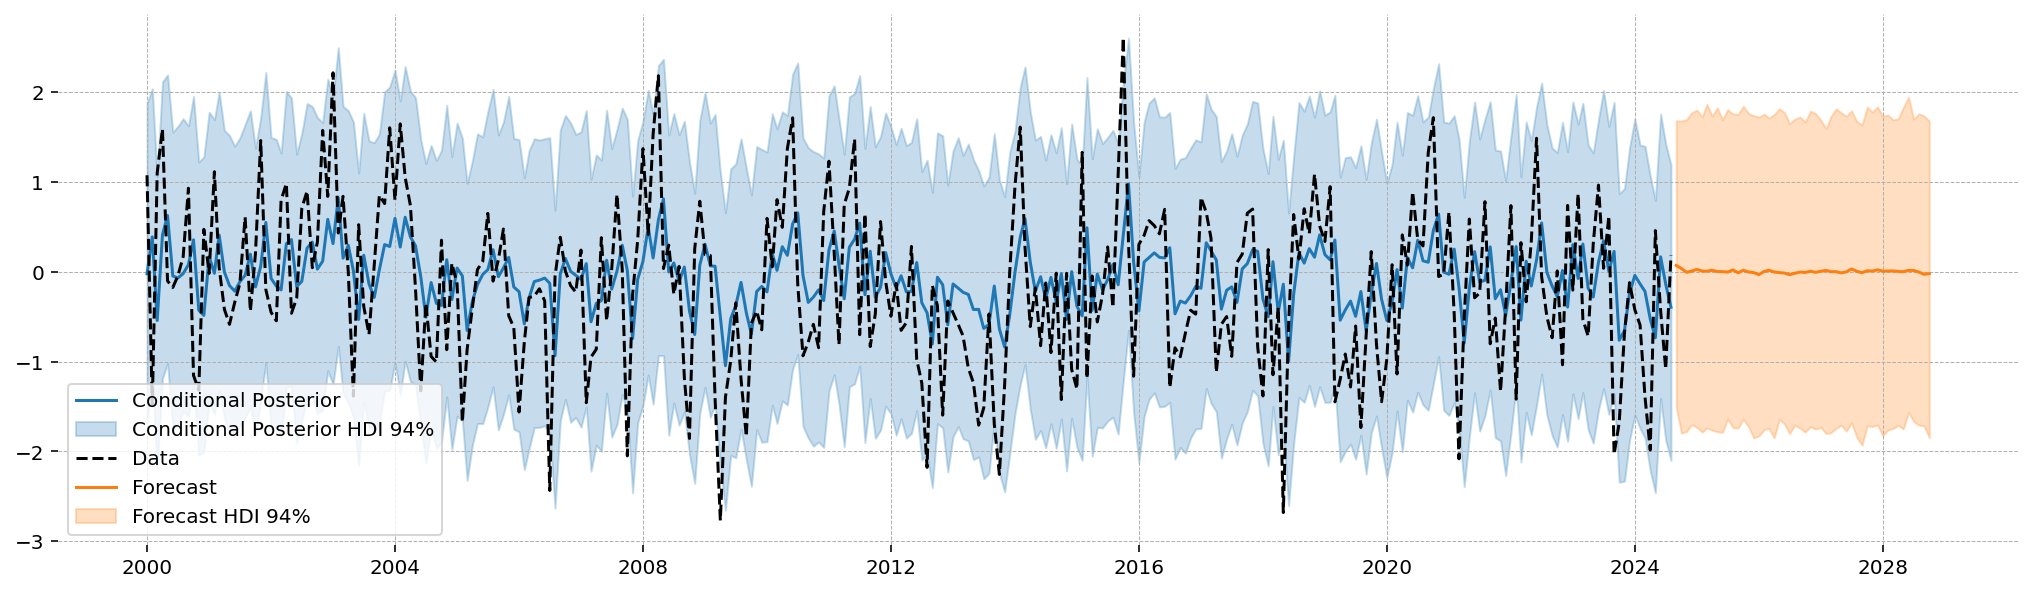

In [20]:
ax = plot_timeseries_posterior(conditional_post.predicted_posterior_observed.isel(observed_state=0), 
                               data=sample.values,
                               label='Conditional Posterior')
ax = plot_timeseries_posterior(idata_forecast.forecast_observed.isel(observed_state=0), 
                               color='tab:orange',
                               label='Forecast',
                               ax=ax)

# Greatness, at what cost?

Hopefully you're impressed with how nice all this is. We can quickly fit a time series model then get samples of the post-estimation quantities we're interested in. Again, we could have done this all in pure PyMC. In that case we're free implemented any model $x_t = g(x_{t-1}, \epsilon_t)$ we wish.

To use the `statespace` module, we're restricted to **Linear Gaussian** models. These models are all of the form:

$$
\begin{align}
x_t &= T_t x_{t-1} + d_t + R_t \epsilon_t \\
y_t &= Z_t x_t + c_t + \eta_t \\
\epsilon_t &\sim N(0, Q_t) \\
\eta_t &\sim N(0, H_t)
\end{align}
$$

Where $x_t$ are the **latent states** of the system, and $y_t$ are the **observed states**. The other objects have the following meanings:

| Name                              | Symbol            | Shape                 |
|-----------------------------------|-------------------|-----------------------|
| Initial hidden state mean         | `x_0`             | `m × 1`               |
| Initial hidden state covariance   | `P_0`             | `m × m`               |
| Hidden state vector intercept     | `c_t`             | `m × 1`               |
| Observed state vector intercept   | `d_t`             | `p × 1`               |
| Transition matrix                 | `T_t`             | `m × m`               |
| Design matrix                     | `Z_t`             | `p × m`               |
| Selection matrix                  | `R_t`             | `m × r`               |
| Observation noise covariance      | `H_t`             | `p × p`               |
| Hidden state innovation covariance| `Q_t`             | `r × r`               |


This linear structure seems restrictive, but you can actually do a lot with it. In the next notebook, we will see a couple examples.

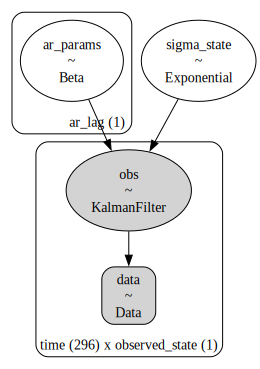

In [29]:
ar1_ss_mod.to_graphviz()

By adopting this structure, we can iteratively calculate the marginal probability distribution of $x_t | x_{t-1}. This recursive calculation is the celebrated **Kalman Filter**. The details of the filter are beyond the scope of this presentation, but if you're interested, I strongly recommend this online course about Kalman filtering:

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

The details aren't so complicated. I'd say it's not rocket science, but it literally is. To prove it, here is a screenshot from the Apollo 11 guidance computer code, available on github [here](https://github.com/chrislgarry/Apollo-11/tree/master/Luminary099):

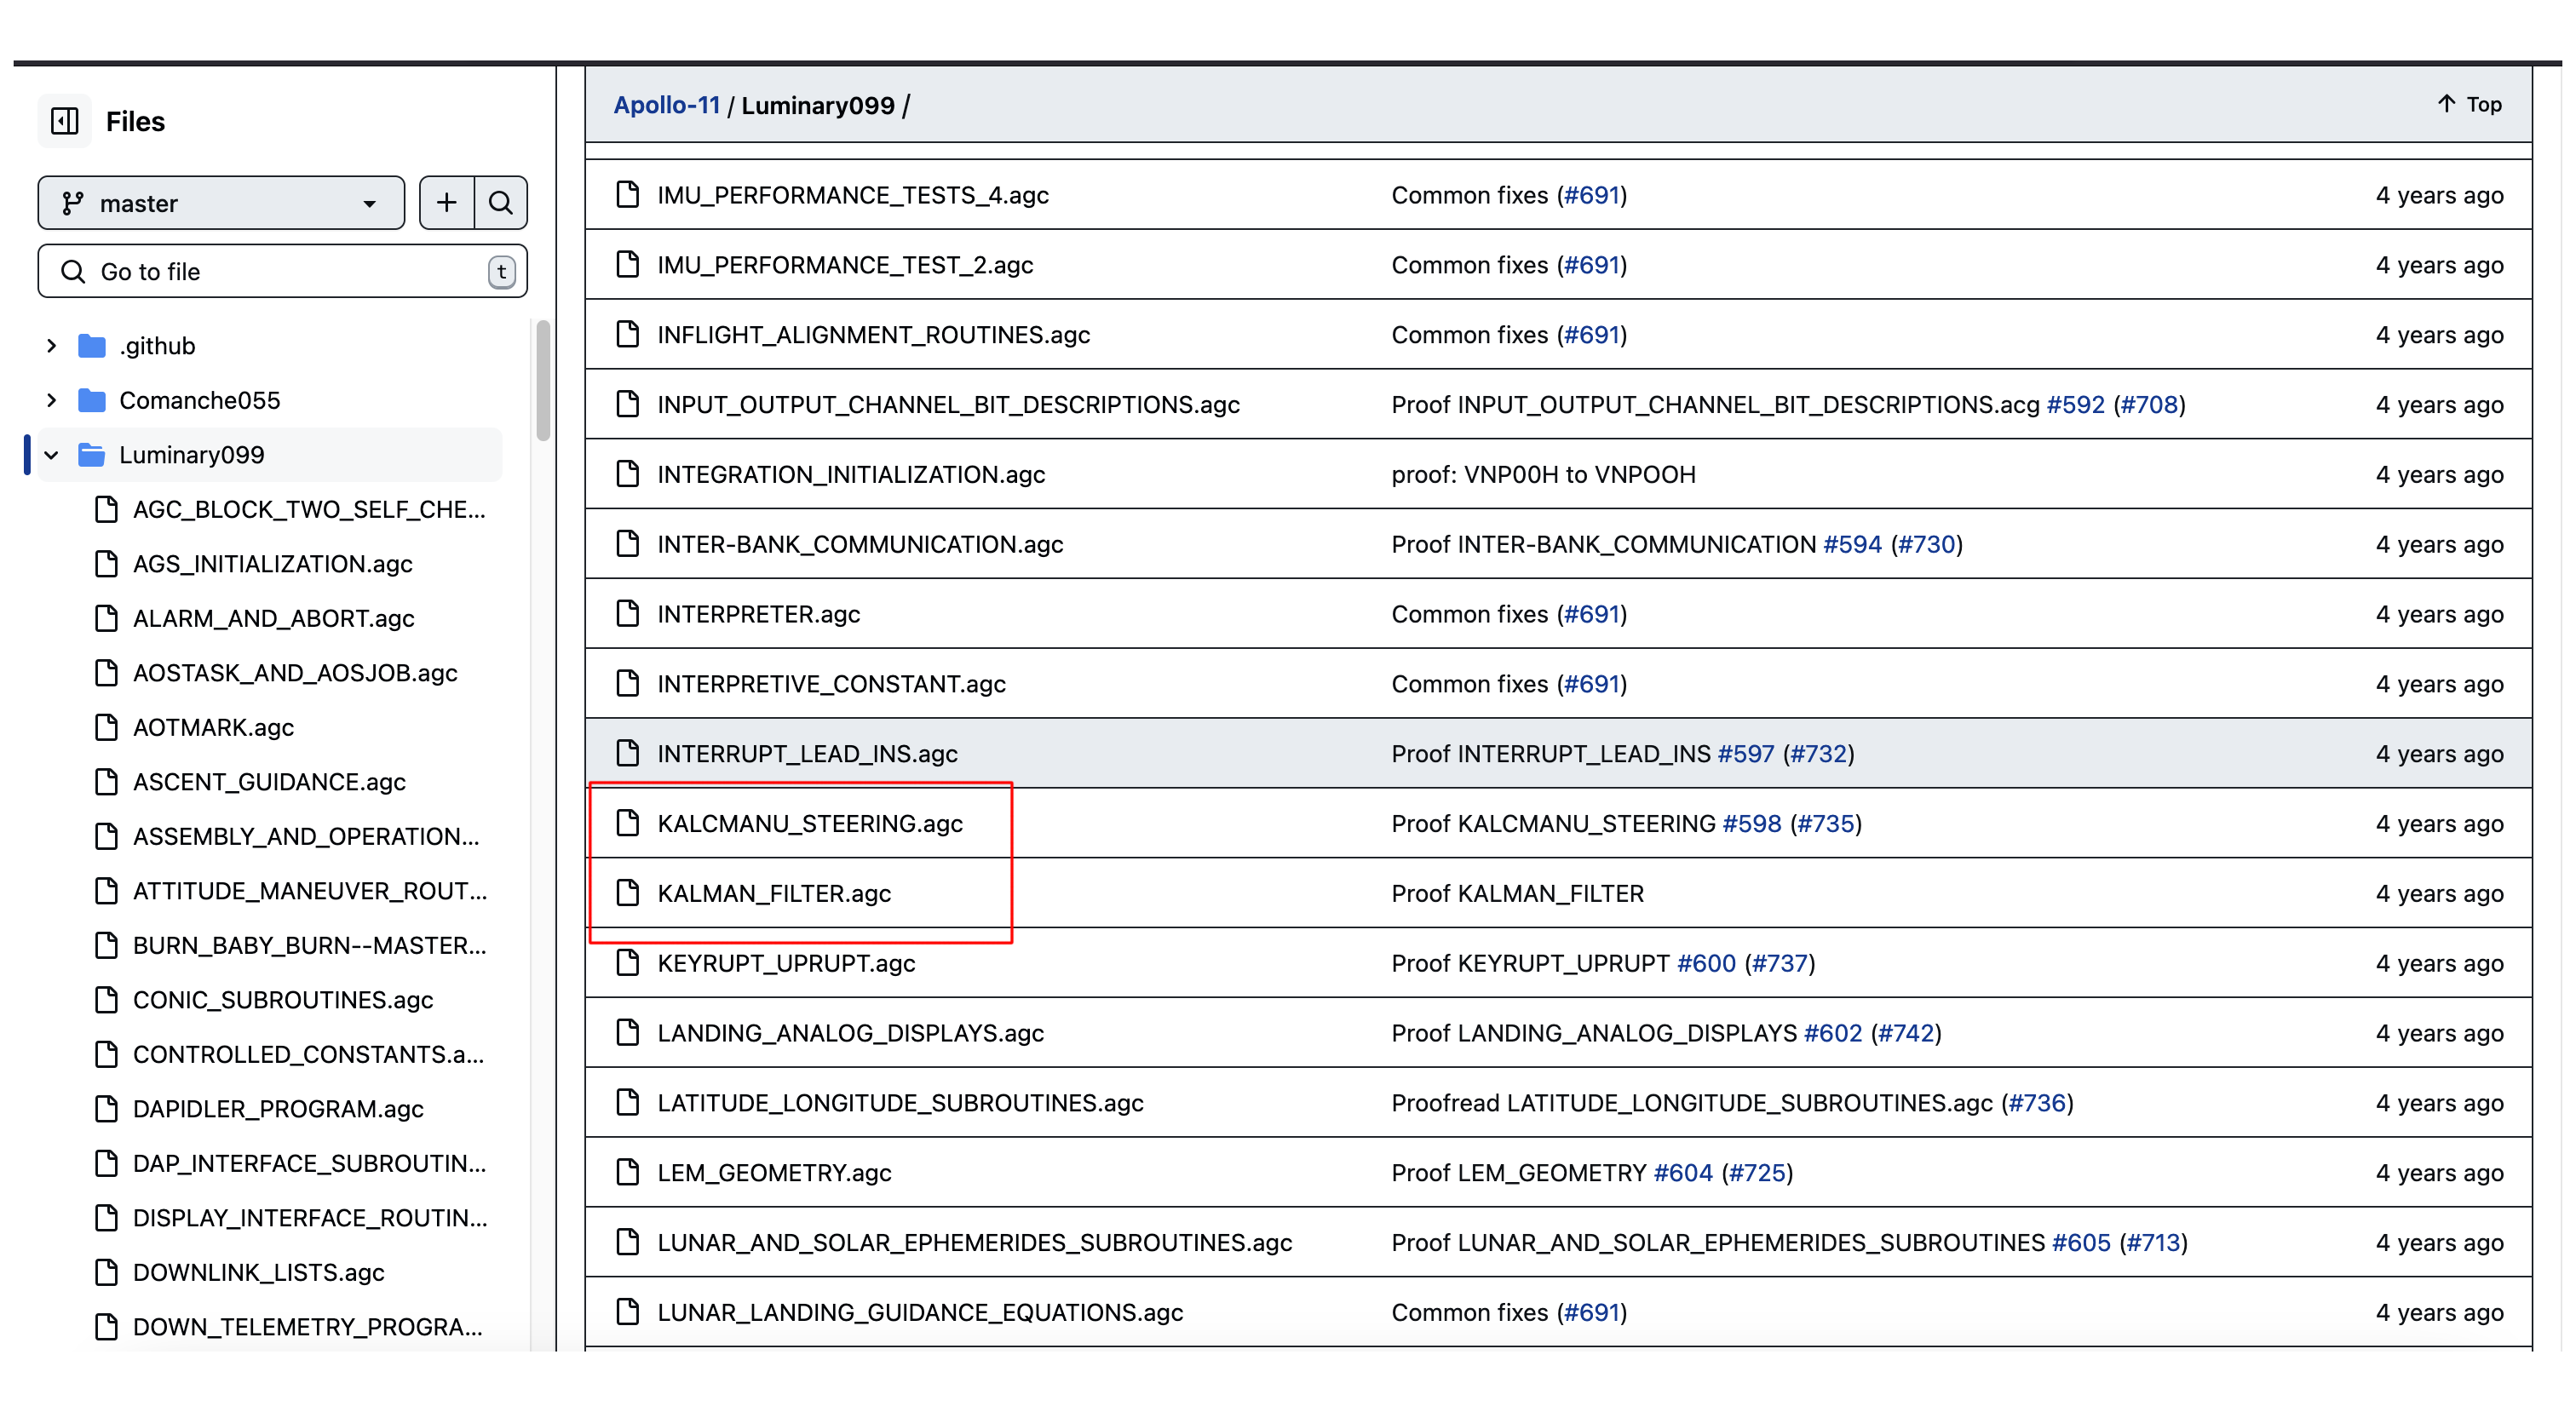

Using the Kalman Filter gives several advantages, mostly related to hidden state inference. The AR(1) model we have looked at is very simple, and thus is easy to express in pure PyMC. For more complex models with several hidden states or several observed states, things get harder. 

In addition, we get optimal estimates of missing data. We can just treat the missing data as a hidden state to be estimated! To drive this point home, let's drop 20 observations from the middle of the sampled series.

In [21]:
sample_with_missing = sample.copy()
sample_with_missing.iloc[25:45] = np.nan

# Exact same model, just pass in the data with missing values
with pm.Model(coords=ss_mod.coords) as ar1_ss_mod:
    pm.Beta('ar_params', 1, 1, dims=['ar_lag'])
    pm.Exponential('sigma_state', lam=1)
    ss_mod.build_statespace_graph(data=sample_with_missing, mode='JAX')
    
    idata_ss_missing = pm.sample(nuts_sampler='numpyro')

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
conditional_post = ss_mod.sample_conditional_posterior(idata_ss_missing)
conditional_post

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

<xarray.Dataset> Size: 57MB
Dimensions:                       (chain: 4, draw: 1000, time: 296, state: 1,
                                   observed_state: 1)
Coordinates:
  * chain                         (chain) int64 32B 0 1 2 3
  * draw                          (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * time                          (time) datetime64[ns] 2kB 2000-01-01 ... 20...
  * state                         (state) <U4 16B 'data'
  * observed_state                (observed_state) <U4 16B 'data'
Data variables:
    filtered_posterior            (chain, draw, time, state) float64 9MB 1.07...
    filtered_posterior_observed   (chain, draw, time, observed_state) float64 9MB ...
    predicted_posterior           (chain, draw, time, state) float64 9MB 0.42...
    predicted_posterior_observed  (chain, draw, time, observed_state) float64 9MB ...
    smoothed_posterior            (chain, draw, time, state) float64 9MB 1.07...
    smoothed_posterior_observed   (chain, draw, time, observed_state) float64 9MB ...
Attributes:
    created_at:                 2024-08-26T14:23:05.146998+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

This exercise can also serve to highlight the difference between the three types of results returned by `sample_conditional_posterior`. Call the data we're feeding into the algorithm at the $t$-th timestep $\mathcal D_t$, then:

1. "predicted" results are one-step ahead forecasts, $x_t | \mathcal D_{t-1}$
2. "filtered" results are our current best belief about the state of the system, accounting for present information: $x_t | \mathcal D_t$
3. "smoothed" results are out best belief about the state of the system, account for all information, present, past, and future: $x_t | \{\mathcal D_\tau\}_{\tau = 0}^T$

We didn't look at filtered and smoothed outputs before because they are only relevant when either 1) your system is subject to measurement error, or 2) you are doing hidden state inference.

Now that we have some missing data, we have some hidden states. Let's look at the difference.

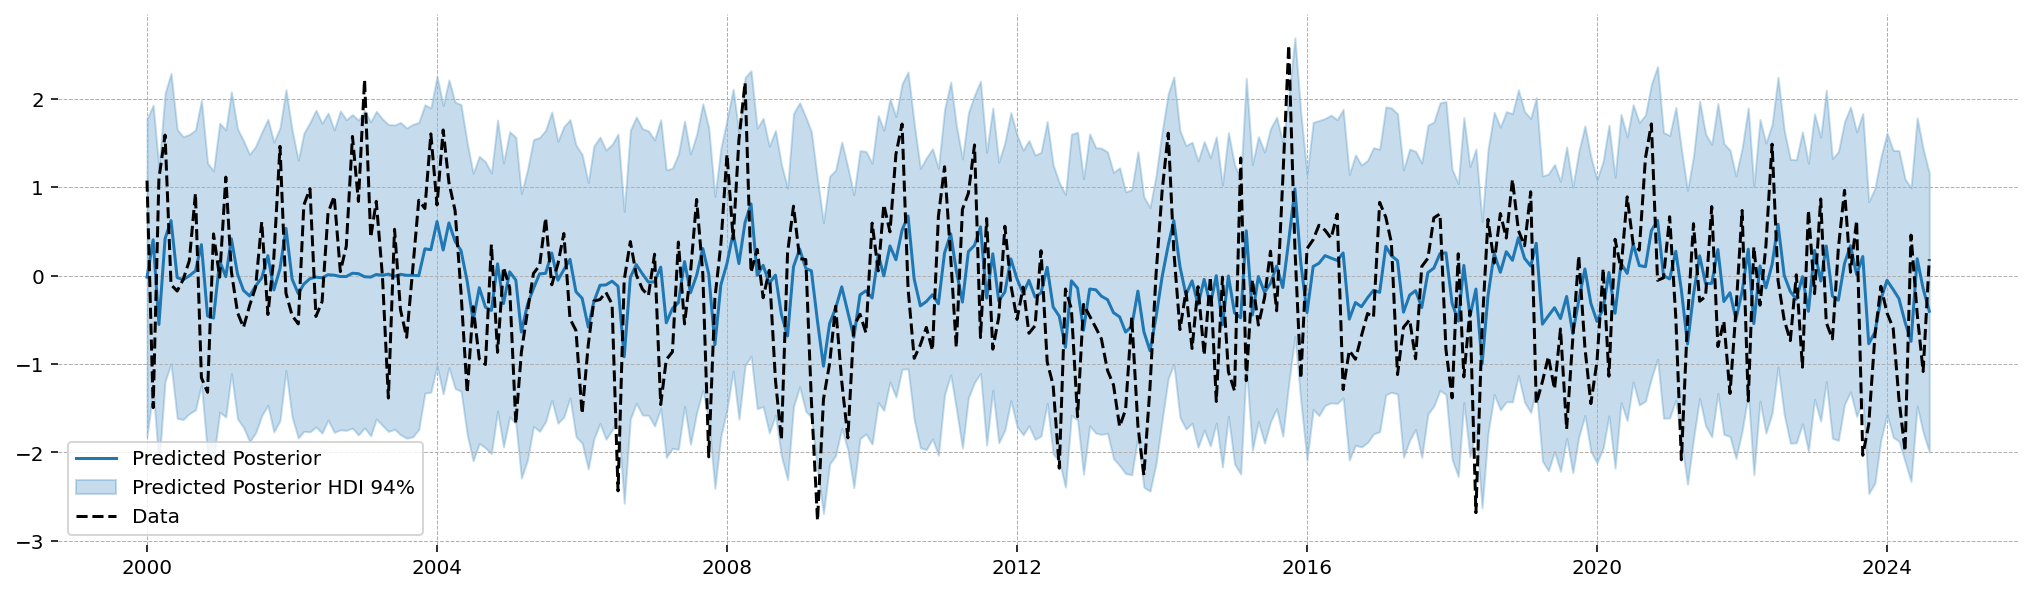

In [23]:
plot_timeseries_posterior(conditional_post.predicted_posterior_observed.isel(observed_state=0),
                          data=sample.values,
                          label='Predicted Posterior');

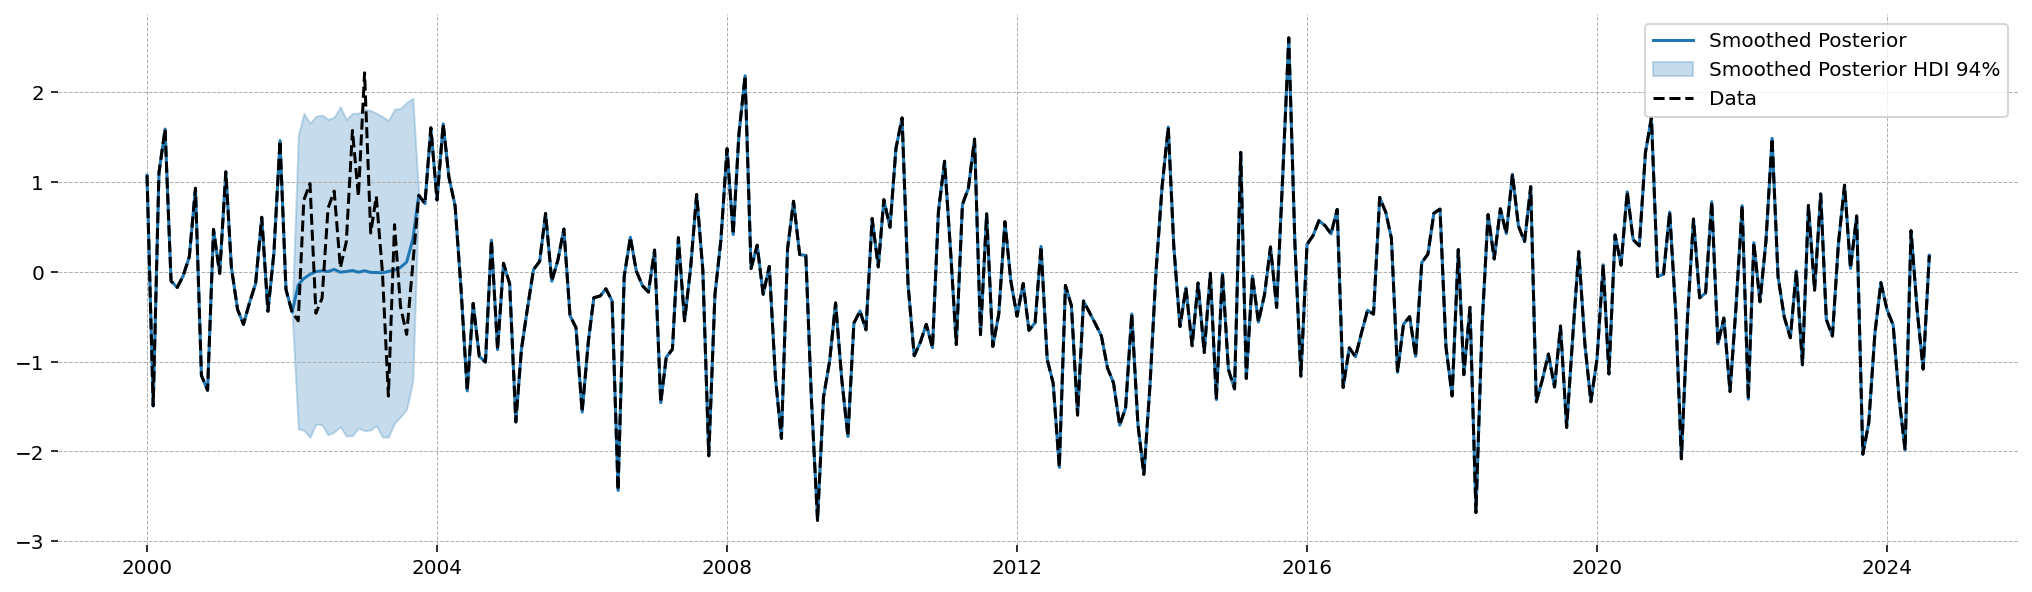

In [24]:
plot_timeseries_posterior(conditional_post.smoothed_posterior_observed.isel(observed_state=0),
                          data=sample.values,
                          label='Smoothed Posterior');

# Advanced: Computing Custom Stuff

If you like, you can use the `ss_mod` to create your own predictive models to compute any quantity of interest from the statespace matrices.

For example, one might want to compute the stationary covariance of the system. This will give us the width of the HDIs we see around the forecasts and interpolations. To get this quantity, we start from the statespace equation:

$$x_t = T x_{t-1} + d + R \varepsilon_t$$

And compute the variance as the expectation of the outer product: $Var(x_t) = \mathbb E[x_t x_t^T]$. Algebra, ho!

$$
\begin{align}
Var(x_t) &= \mathbb E_t[(x_t)(x_t)^T]\\
&= \mathbb E_t[(T x_{t-1} + d + R \varepsilon_t)(T x_{t-1} + d + R \varepsilon_t)^T]\\
&= \mathbb E_t[(T x_{t-1})(T x_{t-1})^T + (R \varepsilon_t) (R \varepsilon_t)^T] \\
&= \mathbb E_t[T x_{t-1} x_{t-1}^T T^T + R \varepsilon_t \varepsilon_t^T R^T] \\
&= T \mathbb E_t[x_{t-1} x_{t-1}^T] T^T + R \mathbb E_t[\varepsilon_t \varepsilon_t^T] R^T \\
\end{align}
$$

Here we invoke the notion of covariance stationarity, that $\mathbb E[x_t x_t^T] = Var(x_t) = Var(x_{t-1}) = \Sigma_x$. Also note that $\mathbb E_t[\varepsilon_t \varepsilon_t^T] = Var(\varepsilon_t) = Q$ so:

$$
\Sigma_x = T \Sigma_x T^T + R Q R^T
$$

This is a discrete Lyapunov equation in $\Sigma_x$, which Pytensor can solve for us using `pt.linalg.solve_discrete_lyapunov`.

In [25]:
with pm.Model(coords=ss_mod.coords) as cov_model:
    ss_mod._build_dummy_graph()
    ss_mod._insert_random_variables()
    
    x0, P0, c, d, T, Z, R, H, Q = ss_mod.unpack_statespace()
    
    # solve_discrete_lyapunov takes 2 arguments, A and Q, such that A @ X @ A^T - X = Q
    # So for us, X = Σ_x, A = T, Q = R @ Q @ R.T
    Σ_x = pt.linalg.solve_discrete_lyapunov(T, R @ Q @ R.T)
    pm.Deterministic('stationary_cov', Σ_x, dims=['state', 'state_aux'])
    idata_cov = pm.compute_deterministics(idata_ss.posterior, var_names=['stationary_cov'])

Output()

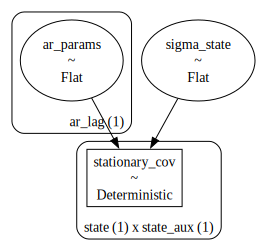

In [26]:
cov_model.to_graphviz()

If everything went correctly, this should be the same as the standard deviation of the samples from the unconditional distribution

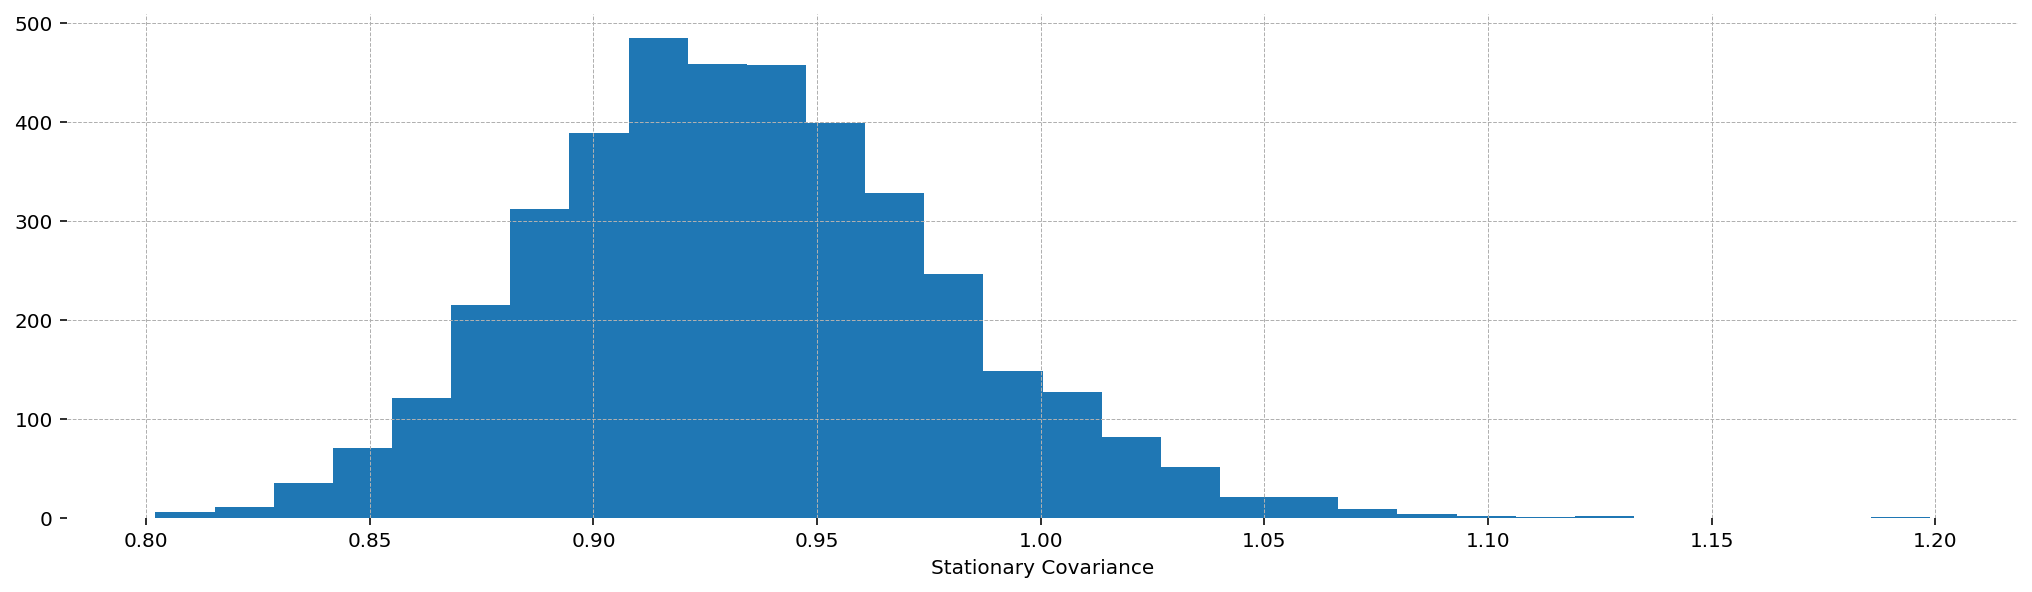

In [27]:
(np.sqrt(idata_cov
             .stationary_cov
             .stack(sample=['chain', 'draw', 'state', 'state_aux']))
     .plot
     .hist(bins=30))
ax = plt.gcf().axes[0]
ax.set(xlabel='Stationary Covariance', title='')
plt.show()